In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  # Returns split words, while tf vectorizes after splitting.

!pip install pyspellchecker
from spellchecker import SpellChecker

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

!pip install tensorflow-hub
!pip install tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0-rc3
Eager mode:  True
Hub version:  0.8.0
GPU is NOT AVAILABLE


## Cleaning Functions:

In [ ]:
# Repurposed function to clean Twitter text:
def clean_text(uncleaned_text):
    # Order of operations:
    # 1. Remove symbols/emojis.
    # 2. Tokenize for subsequent processes.
    # 3. Remove http links.
    # 4. Replace contractions with root words.
    # 5. Remove @whatever.
    # 6. Separate and Remove '_', '#', '/', ''' in that order.
    # 7. Join and return.

    # Identify junk to be removed.
    symbols = ['*', '+', '...', '?', '`', '``', '[', ']', '(', ')', '-', '~', '|', 'â', '€', '™']
    
    emotes = ['\x89Û_', '\x89Ûªt', '\x89', '\x89ÛÏ', '\x89Ûªm', '\x89ÛÓ',
              '\x89Ûª', '\x89Û÷', '\x89ÛªS', 'RAZEDåÊ', '\x89ÛÒ', 'Ûªs']    
    

    def remove_symbols(uncleaned_text):
        for s in symbols:
            uncleaned_text = uncleaned_text.replace(s, ' ')
        uncleaned_text = uncleaned_text.replace('&', ' and ')
        return uncleaned_text


    uncleaned_text = remove_symbols(uncleaned_text)
    
    
    def remove_emote(uncleaned_text):
        for emote in emotes:
            uncleaned_text = uncleaned_text.replace(emote, '')
        return uncleaned_text


    uncleaned_text = remove_emote(uncleaned_text)
    word_tokens = word_tokenize(uncleaned_text)


    def remove_links(word_tokens):
        if 'http' in word_tokens:
            word_tokens = word_tokens[0:word_tokens.index('http')]
        if 'https' in word_tokens:
            word_tokens = word_tokens[0:word_tokens.index('https')]
        return word_tokens


    word_tokens = remove_links(word_tokens)


    def delete_contraction(word_tokens):
        for i, w in enumerate(word_tokens):
            if w == "'d":
                word_tokens[i] = ''
            elif w == "n't":
                word_tokens[i] = 'not'
            elif w == "'m":
                word_tokens[i] = ''
            elif w == "'re":
                word_tokens[i] = ''
            elif w == 'gon':
                word_tokens[i] = 'going to'
            elif w == 'na':
                word_tokens[i] = ''
            elif w == "'s":
                word_tokens[i] = ''
            elif w == "'ll":
                word_tokens[i] = ''
            else:
                pass
        return word_tokens


    word_tokens = delete_contraction(word_tokens)


    def remove_at(word_tokens):  # remove '@' and words followed by @
        j = 0
        for i in range(len(word_tokens)):
            try:
                if word_tokens[j] == '@':
                    del word_tokens[j + 1]
                    del word_tokens[j]
                    j += -1
                j += 1
            except:
                break
        return word_tokens


    word_tokens = remove_at(word_tokens)


    def remove_numbers(word_tokens):
      j = 0
      for i in range(len(word_tokens)):
        try:
          if word_tokens[i-j].isnumeric():
            del word_tokens[i-j]
            j += 1
        except:
          break
      return word_tokens


    word_tokens = remove_numbers(word_tokens)

    cleaned_text = ' '.join(word_tokens).replace('_', ' ')
    cleaned_text = cleaned_text.replace('#', ' ')
    cleaned_text = cleaned_text.replace('/', ' ')
    cleaned_text = cleaned_text.replace("'", ' ')

    return cleaned_text

### Spell-Checker and Remove_Stopwords:

In [ ]:
def spellcheck(input_words):  # Additionally casts to LC and removes excess spaces as a nice side-effect of how it spell-checks.
  speller = SpellChecker()
  words = speller.split_words(input_words)
  [speller.correction(w) for w in words]

  return ' '.join(words)


def remove_stopwords(input_words):
  stop_words = set(stopwords.words('english'))  # List of stopwords to remove
  word_tokens = word_tokenize(input_words)
  words = [w for w in word_tokens if not w in stop_words]

  return ' '.join(words)

In [ ]:
def find_dim(input_text):  # Pass all strings in array, find longest one for padding
  m = 0
  for i in range(len(input_text)):
    word_tokens = word_tokenize(input_text[i])
    m = max(m, len(word_tokens))
  return m

### Other Functions:

In [ ]:
def accuracy(y, y_hat):
    return np.mean(y == y_hat)


def save_spin(ax, name):
  count = 0
  for angle in range(0, 360, 10):
    ax.view_init(15, angle)
    filename='/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/Plots/'+str(name)+'_'+str(count)+'_'+str(angle)+'.png'
    count += 1
    plt.savefig(filename, dpi=96)

## Data Import and Pre-Processing:

### Import cleaned set, or build new one from raw data if cannot:

In [ ]:
# Try to import the cleaned sheet, if it doesn't exist, re-clean the raw data.
try:
  input_file = "/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/Cleaned_News_Titles.csv"
  data = pd.read_csv(input_file).to_numpy()
  print("Cleaned data successfully read from file!")

except FileNotFoundError:
  # Grab Onion set and header from this file.
  input_file = "/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/OnionOrNot.csv"
  df = pd.read_csv(input_file)

  labels = df.columns.values
  X = df.to_numpy()

  # Grab additional Fake News examples and append.
  input_file = "/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/Fake.csv"
  df = pd.read_csv(input_file)

  temp = np.expand_dims(df['title'].to_numpy(), axis=1)
  temp = np.concatenate((temp, np.ones(shape=temp.shape)), axis=1)
  X = np.concatenate((X, temp), axis=0)

  # Grab additional Real News examples and append.
  input_file = "/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/True.csv"
  df = pd.read_csv(input_file)

  temp = np.expand_dims(df['title'].to_numpy(), axis=1)
  temp = np.concatenate((temp, np.zeros(shape=temp.shape)), axis=1)
  X = np.concatenate((X, temp), axis=0)

  # Create total text/label arrays and clean the text.
  y = X[:, 1].astype(int)  # 1 is Fake, 0 Not Fake.
  X = X[:, 0].astype(str)

  for i in range(len(X)):
    X[i] = clean_text(X[i])

  for i in range(len(X)):
    X[i] = spellcheck(X[i])

  for i in range(len(X)):
    X[i] = remove_stopwords(X[i])

  print(X.shape)

  X = np.expand_dims(X, axis=1)
  y = np.expand_dims(y, axis=1)
  data = np.concatenate((X, y), axis=1)
  df = pd.DataFrame(data)
  df.columns = labels

  output_file = "/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/Cleaned_News_Titles.csv"
  df.to_csv(output_file, header=True, index=False)

  print("Cleaned data successfully written to file!")

Cleaned data successfully read from file!


### Pre-Process and Split:

In [ ]:
# Oversample if desired.
numNews = data.shape[0]
print("Number of News:", numNews)
print("Number of Fake News:", len(data[data[:, 1] == 1]))
print("Number of Real News:", len(data[data[:, 1] == 0]))

oversample = False

if oversample:
  num_copies = 1  # Number of copies to add.
  minority = data[:, :][data[:, 1] == 1]
  print(minority.shape)
  
  for i in range(num_copies):
    np.random.shuffle(minority)
    temp = minority
    data = np.append(data, temp[:200, :], axis=0)

numNews = data.shape[0]
print("Final Shape:", data.shape)

Number of News: 68898
Number of Fake News: 32481
Number of Real News: 36417
Final Shape: (68898, 2)


In [ ]:
# Check sizes and split into train and test sets.
np.random.shuffle(data)

# Split into Train, Valid, Test sets.
split = [0.5, 0.4, 0.1]
split[0] = round(numNews*split[0])
for i in range(1, len(split)):
  split[i] = round(numNews*split[i]) + split[i-1]
print(split)

y_train = data[:split[0], 1].astype(int).squeeze()
X_train = data[:split[0], 0].astype(str)
y_valid = data[split[0]:split[1], 1].astype(int).squeeze()
X_valid = data[split[0]:split[1], 0].astype(str)
y_test = data[split[1]:split[2], 1].astype(int).squeeze()
X_test = data[split[1]:split[2], 0].astype(str)

# Print splits, make sure shuffling was done correctly.
print(len(X_train))
print(len(X_valid))
print(len(X_test))

[34449, 62008, 68898]
34449
27559
6890


### Tokenization:

In [ ]:
# Tokenize and standardize lengths for training.
token_len = max(find_dim(X_train.astype(str)), find_dim(X_valid.astype(str)))
print("Padding Length: " + str(token_len))
tokenizer = tf.keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_valid)
# tokenizer.fit_on_texts(X_test)  # Don't fit over test since it's not part of the model.
print("Number of unique words:", len(tokenizer.word_index))

X_train = tokenizer.texts_to_sequences(X_train)  # Vectorizes into numbers
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=token_len, padding='pre', truncating='post')

X_valid = tokenizer.texts_to_sequences(X_valid)  # Vectorizes into numbers
X_valid = tf.keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=token_len, padding='pre', truncating='post')

X_test = tokenizer.texts_to_sequences(X_test)  # Vectorizes into numbers
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=token_len, padding='pre', truncating='post')

Padding Length: 35
Number of unique words: 30500


### Tensorization:

In [ ]:
# Shuffle and batch so the format is correct for embedding.
X_train = tf.constant(X_train, dtype=tf.int64)
y_train = tf.constant(y_train, dtype=tf.int64)
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(100)
print(train_data)

X_valid = tf.constant(X_valid, dtype=tf.int64)
y_valid = tf.constant(y_valid, dtype=tf.int64)
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).shuffle(100).batch(100)
print(valid_data)

X_test = tf.constant(X_test, dtype=tf.int64)
y_test = tf.constant(y_test, dtype=tf.int64)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(100).batch(100)
print(test_data)

<BatchDataset shapes: ((None, 35), (None,)), types: (tf.int64, tf.int64)>
<BatchDataset shapes: ((None, 35), (None,)), types: (tf.int64, tf.int64)>
<BatchDataset shapes: ((None, 35), (None,)), types: (tf.int64, tf.int64)>


## Build and Train Models:

### 2D:

In [ ]:
"""
# Define model layers with Dense over LSTM for Classification
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 1000))
# Flatten to 1D to line up with subsequent layers since Embedding can take multiple and Dense cannot
model.add(tf.keras.layers.LSTM(100, activation="relu", return_sequences=False, recurrent_dropout=0.1))
model.add(tf.keras.layers.Dense(100, activation ="relu"))
model.add(tf.keras.layers.Dense(100, activation ="relu"))
model.add(tf.keras.layers.Dense(100, activation ="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())
"""

'\n# Define model layers with Dense over LSTM for Classification\nmodel = tf.keras.Sequential()\nmodel.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 1000))\n# Flatten to 1D to line up with subsequent layers since Embedding can take multiple and Dense cannot\nmodel.add(tf.keras.layers.LSTM(100, activation="relu", return_sequences=False, recurrent_dropout=0.1))\nmodel.add(tf.keras.layers.Dense(100, activation ="relu"))\nmodel.add(tf.keras.layers.Dense(100, activation ="relu"))\nmodel.add(tf.keras.layers.Dense(100, activation ="relu"))\nmodel.add(tf.keras.layers.Dense(1, activation=\'sigmoid\'))\nprint(model.summary())\n'

In [ ]:
# Define model layers with Dense over LSTM for Classification
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 2))
# Flatten to 1D to line up with subsequent layers since Embedding can take multiple and Dense cannot
model.add(tf.keras.layers.LSTM(100, activation="relu", return_sequences=False, recurrent_dropout=0.1))
model.add(tf.keras.layers.Dense(10, activation ="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 2)           61002     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               41200     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 103,223
Trainable params: 103,223
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Define model parameters after defining layers with compile:
tf.keras.backend.clear_session()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Run the fitting and train the model:
batch_size = 100 # Number of observations run per set
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
MC = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_data, validation_data=valid_data, epochs=4, verbose=1, batch_size=batch_size, callbacks = [ES, MC])

Epoch 1/4
345/345 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.7186
Epoch 00001: val_accuracy improved from -inf to 0.84299, saving model to best_model.h5
345/345 [==============================] - 32s 94ms/step - loss: 0.5924 - accuracy: 0.7186 - val_loss: 0.3983 - val_accuracy: 0.8430
Epoch 2/4
345/345 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.8625
Epoch 00002: val_accuracy improved from 0.84299 to 0.86886, saving model to best_model.h5
345/345 [==============================] - 32s 93ms/step - loss: 0.3478 - accuracy: 0.8625 - val_loss: 0.3114 - val_accuracy: 0.8689
Epoch 3/4
345/345 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9088
Epoch 00003: val_accuracy improved from 0.86886 to 0.87173, saving model to best_model.h5
345/345 [==============================] - 32s 93ms/step - loss: 0.2283 - accuracy: 0.9088 - val_loss: 0.3187 - val_accuracy: 0.8717
Epoch 4/4
345/345 [==============================

### 3D

In [ ]:
# Define model layers with Dense over LSTM for Classification
model3D = tf.keras.Sequential()
model3D.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 3))
# Flatten to 1D to line up with subsequent layers since Embedding can take multiple and Dense cannot
model3D.add(tf.keras.layers.LSTM(100, activation="relu", return_sequences=False, recurrent_dropout=0.1))
model3D.add(tf.keras.layers.Dense(10, activation ="relu"))
model3D.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model3D.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 3)           91503     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               41600     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 134,124
Trainable params: 134,124
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Define model3D parameters after defining layers with compile:
tf.keras.backend.clear_session()
model3D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Run the fitting and train model3D:
batch_size = 100 # Number of observations run per set
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
MC = tf.keras.callbacks.ModelCheckpoint('best_model3D.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model3D.fit(train_data, validation_data=valid_data, epochs=5, verbose=1, batch_size=batch_size, callbacks = [ES, MC])

Epoch 1/5
345/345 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.7141
Epoch 00001: val_accuracy improved from -inf to 0.82880, saving model to best_model3D.h5
345/345 [==============================] - 32s 94ms/step - loss: 0.6132 - accuracy: 0.7141 - val_loss: 0.4323 - val_accuracy: 0.8288
Epoch 2/5
345/345 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8662
Epoch 00002: val_accuracy improved from 0.82880 to 0.86251, saving model to best_model3D.h5
345/345 [==============================] - 32s 94ms/step - loss: 0.3345 - accuracy: 0.8662 - val_loss: 0.3701 - val_accuracy: 0.8625
Epoch 3/5
345/345 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9088
Epoch 00003: val_accuracy improved from 0.86251 to 0.87590, saving model to best_model3D.h5
345/345 [==============================] - 32s 93ms/step - loss: 0.2285 - accuracy: 0.9088 - val_loss: 0.3411 - val_accuracy: 0.8759
Epoch 4/5
345/345 [========================

## Predict and Metrics:

### Build-in Metrics:

In [ ]:
results = model.evaluate(test_data, verbose=2)

69/69 - 1s - loss: 0.2906 - accuracy: 0.8820


In [ ]:
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.291
accuracy: 0.882


In [ ]:
y_hat = model.predict_classes(X_test).reshape(len(y_test), 1)
print(len(y_hat))
print(type(y_hat))
print(len(y_hat[y_hat==1]))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
6890
<class 'numpy.ndarray'>
3120


0.8820029027576197


(2.0, 0.0)

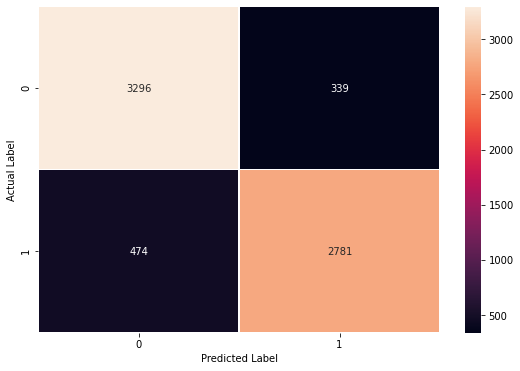

In [ ]:
# Make Confusion Matrix
print(accuracy(y_test.numpy().reshape(-1, 1), y_hat))
plt.figure(figsize=(9, 6))
y_true = pd.Series(y_test.numpy().squeeze(), name="Actual Label")
y_pred = pd.Series(y_hat.squeeze(), name="Predicted Label")
sns.heatmap(pd.crosstab(y_true, y_pred), annot=True, fmt="d", linewidths=0.25)
plt.ylim(len(set(y_test.numpy())), 0)  # Fix limits, matplotlib bugged (ver. 3.11)

In [ ]:
"""
output = np.concatenate((data[split[1]:split[2], 0:1].reshape(-1, 1), y_hat, y_test.numpy().reshape(-1, 1)), axis=1)
df = pd.DataFrame(output)
df.columns = ['Text', 'Prediction', 'Label']

output_file = "/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/Predictions.csv"
df.to_csv(output_file, header=True, index=False)
"""

'\noutput = np.concatenate((data[split[1]:split[2], 0:1].reshape(-1, 1), y_hat, y_test.numpy().reshape(-1, 1)), axis=1)\ndf = pd.DataFrame(output)\ndf.columns = [\'Text\', \'Prediction\', \'Label\']\n\noutput_file = "/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/Predictions.csv"\ndf.to_csv(output_file, header=True, index=False)\n'

### Adjusted Threshold:

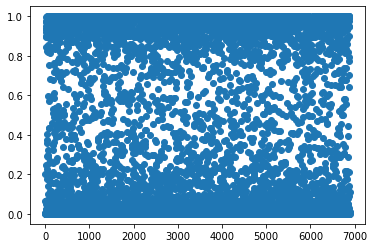

In [ ]:
y_hat = model.predict(X_test).reshape(len(y_test), 1)

temp = []
for i in range(len(y_hat)):
  temp.append(i)
temp = np.array(temp)

plt.scatter(temp, y_hat)

In [ ]:
# Determine best threshold
thresholds = []
max_thresh = 0
max_test = 0
steps = 100
for i in range(steps):
  thresholds.append(i * (1/steps))

temp = np.zeros(shape=y_hat.shape)

for thresh in thresholds:
  for i in range(len(y_hat)):
    if y_hat[i] <= thresh:
      temp[i] = 0
    else:
      temp[i] = 1

  test = accuracy(y_test.numpy().reshape(-1, 1), temp)
  if test > max_test:
    max_test = test
    max_thresh = thresh

print("Treshold Accuracy:", max_test)
print("Threshold Value", max_thresh)

Treshold Accuracy: 0.8820029027576197
Threshold Value 0.5


0.879245283018868


(2.0, 0.0)

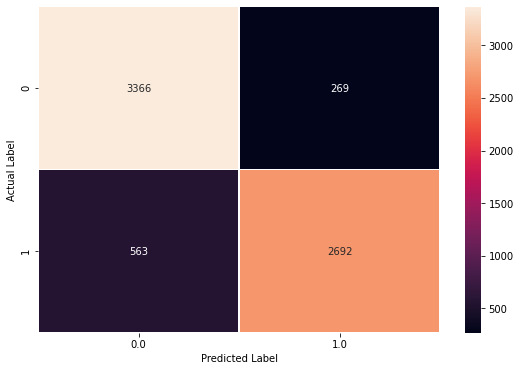

In [ ]:
# Make Confusion Matrix
for i in range(len(y_hat)):
  if y_hat[i] <= 0.6:
    temp[i] = 0
  else:
    temp[i] = 1

print(accuracy(y_test.numpy().reshape(-1, 1), temp))
plt.figure(figsize=(9, 6))
y_true = pd.Series(y_test.numpy().squeeze(), name="Actual Label")
y_pred = pd.Series(temp.squeeze(), name="Predicted Label")
sns.heatmap(pd.crosstab(y_true, y_pred), annot=True, fmt="d", linewidths=0.25)
plt.ylim(len(set(y_test.numpy())), 0)  # Fix limits, matplotlib bugged (ver. 3.11)

## Visualize Concept Space:

In [ ]:
# Grab all unique words:
single_words = []
single_vecs = []

for k, v in tokenizer.word_index.items():
  single_words.append(k)
  single_vecs.append([v])

single_words = np.array(single_words).reshape(-1, 1)
single_vecs = tf.keras.preprocessing.sequence.pad_sequences(single_vecs, padding = 'pre', truncating = 'post', maxlen = token_len)
print(single_words.shape, single_vecs.shape)

(30500, 1) (30500, 35)


In [ ]:
# Determine most important words for each class:
importance = model.predict(single_vecs).reshape(len(single_vecs), 1)
importance = np.concatenate((single_words, importance), axis=1)
importance = importance[np.argsort(importance[:, 1])][::-1]

# Sanity check:
print(importance[0, 1], importance[-1, 1])
print(max(importance[:, 1]), min(importance[:, 1]))
print(importance.shape)

# Grab words of interest from sorted array to plt:
numwords = 10
fake = importance[0:numwords, 0]
real = importance[importance.shape[0]-numwords:importance.shape[0], 0]
print(fake.shape, real.shape)
print(fake)
print(real)

0.8999465 0.0035849214
0.8999465 0.0035849214
(30500, 2)
(10,) (10,)
['video' 'breaking' 'hillary' 'watch' 'wow' 'awesome' 'bombshell' 'ck'
 'guess' 'illegals']
['jailed' 'says' 'seek' 'ireland' 'reuters' 'rohingya' 'myanmar'
 'spokesman' 'catalan' 'factbox']


In [ ]:
# Manually define plotted words to avoid profanity or nonsense on plot:
fake_choice = ['video', 'hilarious', 'breaking', 'hillary', 'nation', 'audio', 'illegals', 'images', 'disgusting', 'leftist', 'borders', 'bernie', 'communities', 'protestors', 'neighborhood']
real_choice = ['spokesman', 'sources', 'zimbabwe', 'ireland', 'spain', 'kremlin', 'catalan', 'macron', 'brexit', 'india', 'jailed', 'talks', 'ghosts', 'diplomacy', 'watchdog']
choice = ['trump', 'illuminati', 'disease', 'unions', 'alligators', 'political']
print(len(fake_choice), len(real_choice), len(choice))

15 15 6


In [ ]:
write = False
if write:
  df = pd.DataFrame(importance)
  df.columns = ['Text', 'Value']

  output_file = "/content/drive/My Drive/Colab Notebooks/Individual Projects/Fake News/Word_Importance.csv"
  df.to_csv(output_file, header=True, index=False)

### 2D:

In [ ]:
# Grab vectorization and of unique words
embed = tf.keras.models.Model(inputs = model.inputs, outputs = model.get_layer('embedding').output)
f = embed.predict(single_vecs)
# print(f)

AttributeError: ignored

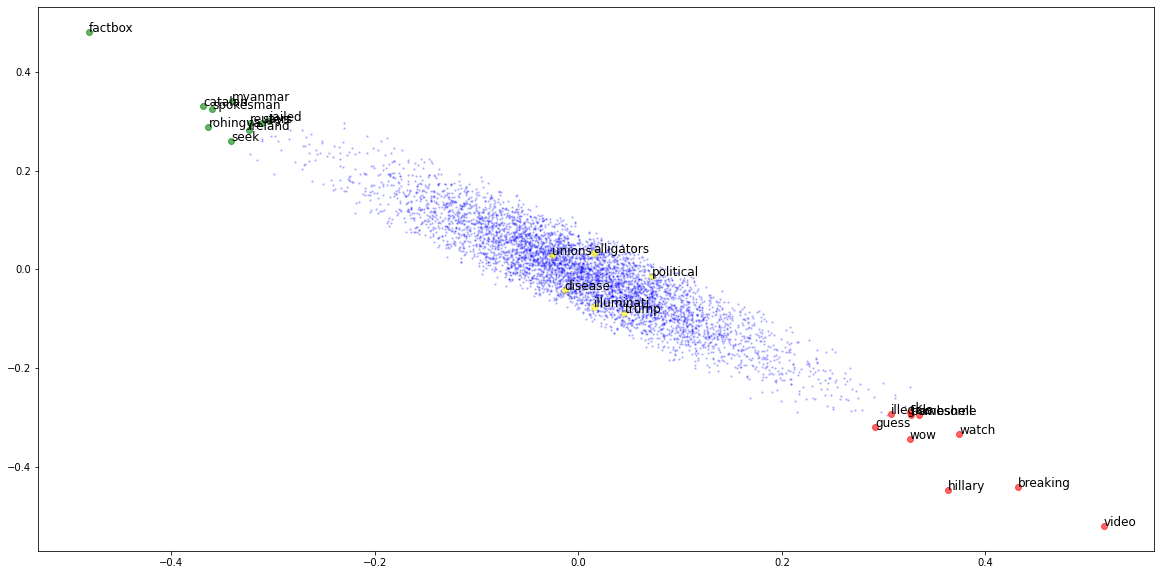

In [ ]:
# Plot highest-valued words in 2D concept space:
plt.figure(figsize = (20, 10))
center = []
count = 0
numpoints = 5000

for i, (k, v) in enumerate(tokenizer.word_index.items()):
  if k in fake:
    plt.text(f[i, -1, 0], f[i, -1, 1], k, fontsize=12)
    plt.scatter(f[i, -1, 0], f[i, -1, 1], color = 'red', alpha = 0.6)
  elif k in real:
    plt.text(f[i, -1, 0], f[i, -1, 1], k, fontsize=12)
    plt.scatter(f[i, -1, 0], f[i, -1, 1], color = 'green', alpha = 0.6)
  elif k in choice:
    plt.text(f[i, -1, 0], f[i, -1, 1], k, fontsize=12)
    plt.scatter(f[i, -1, 0], f[i, -1, 1], color = 'yellow', alpha = 0.6)
  elif i < numpoints:
    plt.scatter(f[i, -1, 0], f[i, -1, 1], s = 2, color = 'blue', alpha = 0.2)

  if count < 20:
    if (0 < abs(f[i, -1, 0]) < 0.01) and (0 < abs(f[i, -1, 1]) < 0.01):
      count += 1
      center.append(k)

plt.set_title('Embedding Outputs: (Real/Fake)\n Center: {}'.format(center), fontsize = 12)
plt.set_xlabel('Embedding Dimension 1')
plt.set_ylabel('Embedding Dimension 2')

In [ ]:
# Plot select words in 2D concept space:
plt.figure(figsize = (20, 10))
center = []
count = 0
numpoints = 5000

for i, (k, v) in enumerate(tokenizer.word_index.items()):
  if k in fake_choice:
    plt.text(f[i, -1, 0], f[i, -1, 1], k, fontsize=12)
    plt.scatter(f[i, -1, 0], f[i, -1, 1], color = 'red', alpha = 0.6)
  elif k in real_choice:
    plt.text(f[i, -1, 0], f[i, -1, 1], k, fontsize=12)
    plt.scatter(f[i, -1, 0], f[i, -1, 1], color = 'green', alpha = 0.6)
  elif k in choice:
    plt.text(f[i, -1, 0], f[i, -1, 1], k, fontsize=12)
    plt.scatter(f[i, -1, 0], f[i, -1, 1], color = 'yellow', alpha = 0.6)
  elif i < numpoints:
    plt.scatter(f[i, -1, 0], f[i, -1, 1], s = 2, color = 'blue', alpha = 0.2)

  if count < 20:
    if (0 < abs(f[i, -1, 0]) < 0.01) and (0 < abs(f[i, -1, 1]) < 0.01):
      count += 1
      center.append(k)

plt.set_title('Embedding Outputs: (Real/Fake)\n Center: {}'.format(center), fontsize = 12)
plt.set_xlabel('Embedding Dimension 1')
plt.set_ylabel('Embedding Dimension 2')

### 3D:

In [ ]:
# Grab vectorization and of unique words
embed = tf.keras.models.Model(inputs = model3D.inputs, outputs = model3D.get_layer('embedding').output)
f = embed.predict(single_vecs)
# print(f)

In [ ]:
# Plot highest-valued words in 3D concept space:
ax = Axes3D(plt.figure(figsize = (20, 10)))
center = []
count = 0
numpoints = 5000

for i, (k, v) in enumerate(tokenizer.word_index.items()):
  if k in fake:
    ax.text(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], k, None, fontsize=12)
    ax.scatter(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], color = 'red', alpha = 0.6)
  elif k in real:
    ax.text(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], k, None, fontsize=12)
    ax.scatter(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], color = 'green', alpha = 0.6)
  elif k in choice:
    ax.text(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], k, None, fontsize=12)
    ax.scatter(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], color = 'yellow', alpha = 0.6)
  elif i < numpoints:
    ax.scatter(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], s = 2, color = 'blue', alpha = 0.2)

  if count < 20:
    if (0 < abs(f[i, -1, 0]) < 0.01) and (0 < abs(f[i, -1, 1]) < 0.01) and (0 < abs(f[i, -1, 2]) < 0.01):
      count += 1
      center.append(k)

ax.set_title('Embedding Outputs: (Real/Fake)\n Center: {}'.format(center), fontsize = 12)
ax.set_xlabel('Embedding Dimension 1')
ax.set_ylabel('Embedding Dimension 2')
ax.set_zlabel('Embedding Dimension 3')

# save_spin(ax, '3D_Concept_Space')

In [ ]:
# Plot highest-valued words in 3D concept space:
ax = Axes3D(plt.figure(figsize = (20, 10)))
center = []
count = 0
numpoints = 5000

for i, (k, v) in enumerate(tokenizer.word_index.items()):
  if k in fake_choice:
    ax.text(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], k, None, fontsize=12)
    ax.scatter(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], color = 'red', alpha = 0.6)
  elif k in real_choice:
    ax.text(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], k, None, fontsize=12)
    ax.scatter(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], color = 'green', alpha = 0.6)
  elif k in choice:
    ax.text(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], k, None, fontsize=12)
    ax.scatter(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], color = 'yellow', alpha = 0.6)
  elif i < numpoints:
    ax.scatter(f[i, -1, 0], f[i, -1, 1], f[i, -1, 2], s = 2, color = 'blue', alpha = 0.2)

  if count < 20:
    if (0 < abs(f[i, -1, 0]) < 0.01) and (0 < abs(f[i, -1, 1]) < 0.01) and (0 < abs(f[i, -1, 2]) < 0.01):
      count += 1
      center.append(k)

ax.set_title('Embedding Outputs: (Real/Fake)\n Center: {}'.format(center), fontsize = 12)
ax.set_xlabel('Embedding Dimension 1')
ax.set_ylabel('Embedding Dimension 2')
ax.set_zlabel('Embedding Dimension 3')

# save_spin(ax, '3D_Concept_Space_Choice')